In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import math
!pip install shap
!pip install keras_tuner
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
#import shap
from sklearn.metrics import roc_curve, auc





In [ ]:
df= pd.DataFrame(pd.read_csv('/content/drive/MyDrive/Projects/Professor Test/heart_failure_clinical_records_dataset-1-1.csv'))
df

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


In [ ]:
def check(df):
    l=[]
    columns=df.columns
    for col in columns:
        dtypes=df[col].dtypes
        nunique=df[col].nunique()
        sum_null=df[col].isnull().sum()
        l.append([col,dtypes,nunique,sum_null])
    df_check=pd.DataFrame(l)
    df_check.columns=['column','dtypes','nunique','sum_null']
    return df_check
check(df)

,column,dtypes,nunique,sum_null
0,age,float64,47,0
1,anaemia,int64,2,0
2,creatinine_phosphokinase,int64,208,0
3,diabetes,int64,2,0
4,ejection_fraction,int64,17,0
5,high_blood_pressure,int64,2,0
6,platelets,float64,176,0
7,serum_creatinine,float64,40,0
8,serum_sodium,int64,27,0
9,sex,int64,2,0


Ok. There is no missing value.

why "age" is float?

categorical features = anaemia , diabetes , high_blood_pressure	, sex , smoking , DEATH_EVENT

Numerical features = age , creatinine_phosphokinase , ejection_fraction , platelets , serum_creatinine , serum_sodium , time

In [ ]:
cat_col = ["anaemia" , "diabetes" , "high_blood_pressure"	, "sex" , "smoking" , "DEATH_EVENT"]
Num_col= ["age" , "creatinine_phosphokinase" , "ejection_fraction" , "platelets" , "serum_creatinine" , "serum_sodium" , "time"]

In [ ]:
temp = df[Num_col].describe()
temp.style.background_gradient(cmap='Oranges')

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,time
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000
mean,60.833893,581.839465,38.083612,263358.029264,1.393880,136.625418,130.260870
std,11.894809,970.287881,11.834841,97804.236869,1.034510,4.412477,77.614208
min,40.000000,23.000000,14.000000,25100.000000,0.500000,113.000000,4.000000
25%,51.000000,116.500000,30.000000,212500.000000,0.900000,134.000000,73.000000
50%,60.000000,250.000000,38.000000,262000.000000,1.100000,137.000000,115.000000
75%,70.000000,582.000000,45.000000,303500.000000,1.400000,140.000000,203.000000
max,95.000000,7861.000000,80.000000,850000.000000,9.400000,148.000000,285.000000


In [ ]:
#pio.renderers.default = 'browser'


plt.style.use('fivethirtyeight')
def fig(df, var):
    fig2 = px.histogram(df, x=var, color=var, template='plotly_dark')
    fig2.show()


In [ ]:
for i in cat_col:
    fig (df,i)

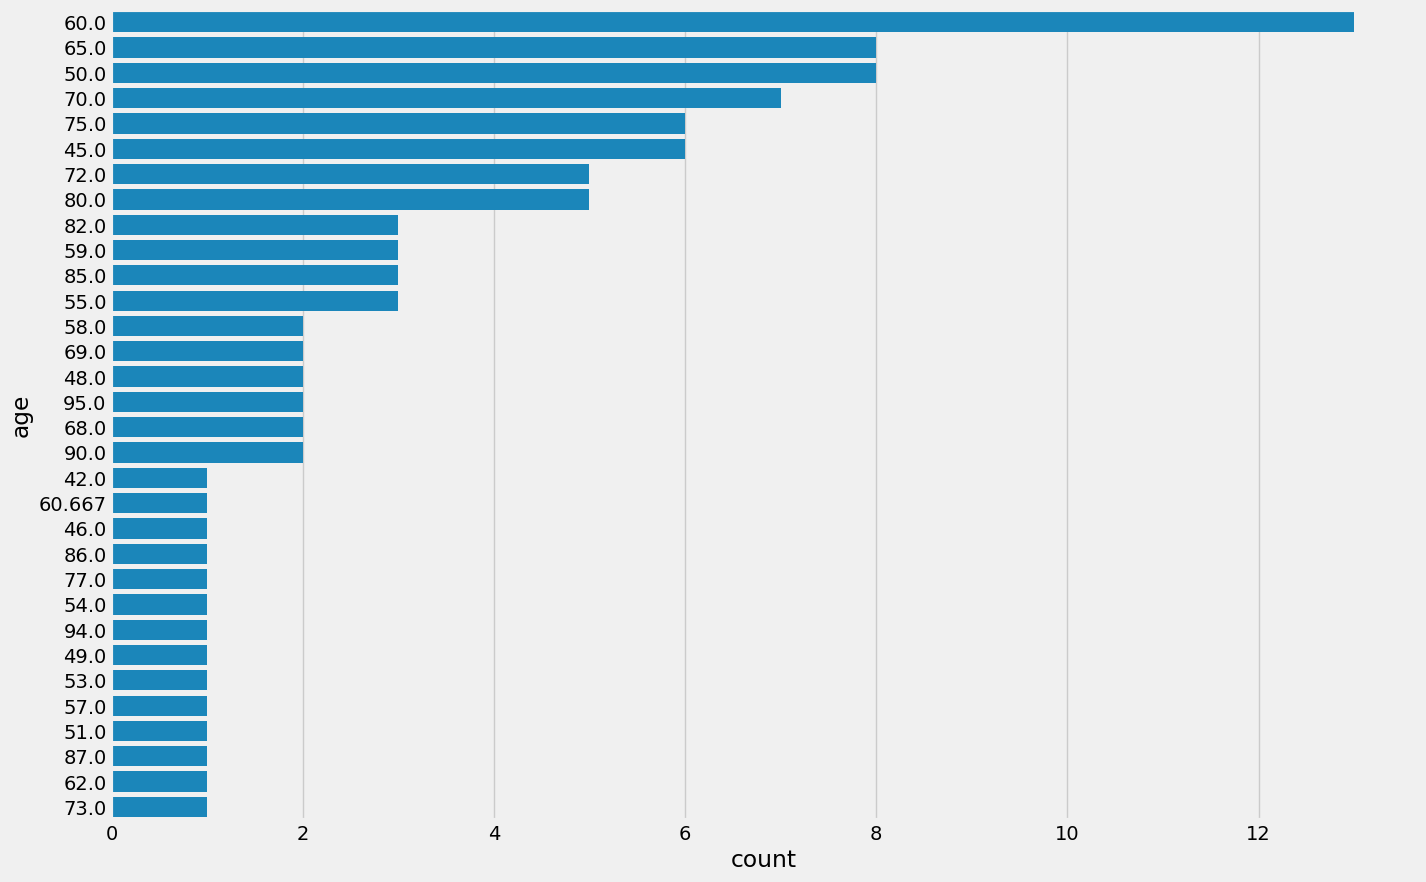

In [ ]:
plt.figure(figsize=(15, 10))
sns.countplot(y=df[df.DEATH_EVENT==1]['age'],
              data=df,
              order=df[df.DEATH_EVENT==1]['age'].value_counts().index[:40]);


What is that? age = 60.667 ???

In [ ]:
decimal_ages = df[df['age'] % 1 != 0]
print(decimal_ages)


        age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
185  60.667        1                       104         1                 30   
188  60.667        1                       151         1                 40   

     high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  \
185                    0   389000.0               1.5           136    1   
188                    1   201000.0               1.0           136    0   

     smoking  time  DEATH_EVENT  
185        0   171            1  
188        0   172            0  


Ok. it's look like we have 2 float num in age col.

In [ ]:
df.loc[df['age'] == 60.667, 'age'] = 61


In [ ]:
print(df[df['age'] == 61])


      age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
128  61.0        0                       248         0                 30   
143  61.0        1                        84         0                 40   
185  61.0        1                       104         1                 30   
188  61.0        1                       151         1                 40   
245  61.0        1                        80         1                 38   
264  61.0        0                       582         1                 38   

     high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  \
128                    1   267000.0               0.7           136    1   
143                    1   229000.0               0.9           141    0   
185                    0   389000.0               1.5           136    1   
188                    1   201000.0               1.0           136    0   
245                    0   282000.0               1.4           137    1   
264 

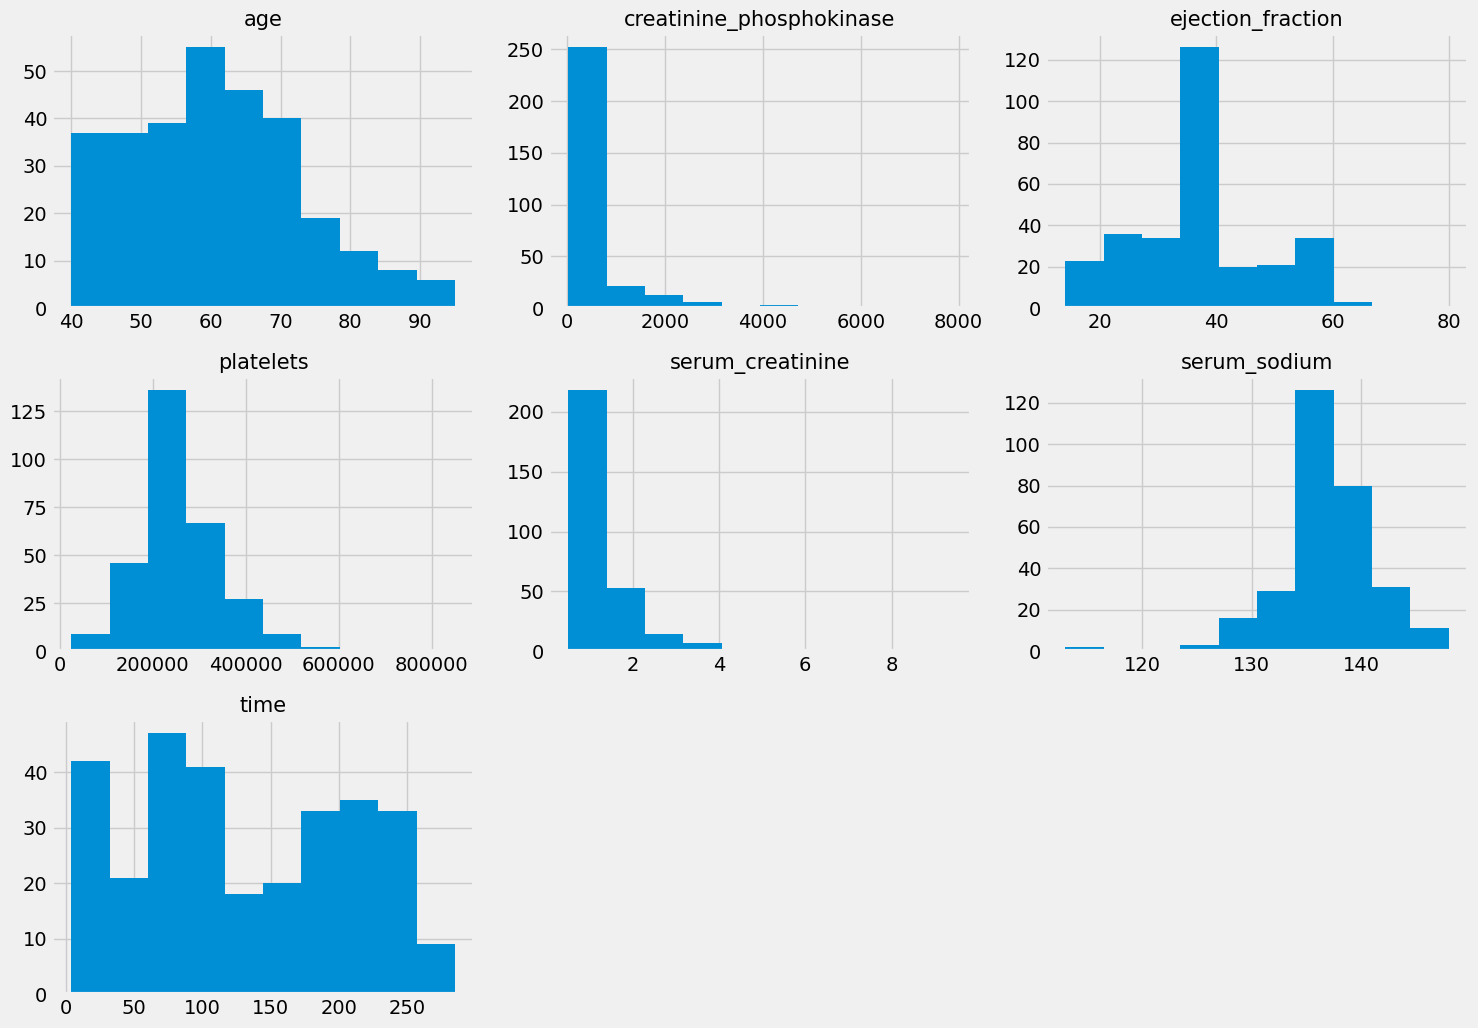

In [ ]:
n_rows = math.ceil(len(Num_col)/3)
plt.figure(figsize=(15, n_rows*3.5))
for i, Num_col in enumerate(list(Num_col)):
    plt.subplot(n_rows, 3, i+1)
    plt.hist(df[Num_col])
    plt.tight_layout()
    plt.title(Num_col, fontsize=15);

In [ ]:
def show_boxplots(cols: list, feature: str, show_fliers=True, data=df):
    n_rows = math.ceil(len(cols)/2)
    plt.figure(figsize=(15, n_rows*5))
    for i, variable in enumerate(cols):
        plt.subplot(n_rows, 2, i+1)
        if show_fliers:
            sns.boxplot(data[feature], data[variable], palette="mako", showfliers=True)
        else:
            sns.boxplot(data[feature], data[variable], palette="mako", showfliers=False)
        plt.tight_layout()
        plt.title(variable, fontsize=12)
    plt.show()

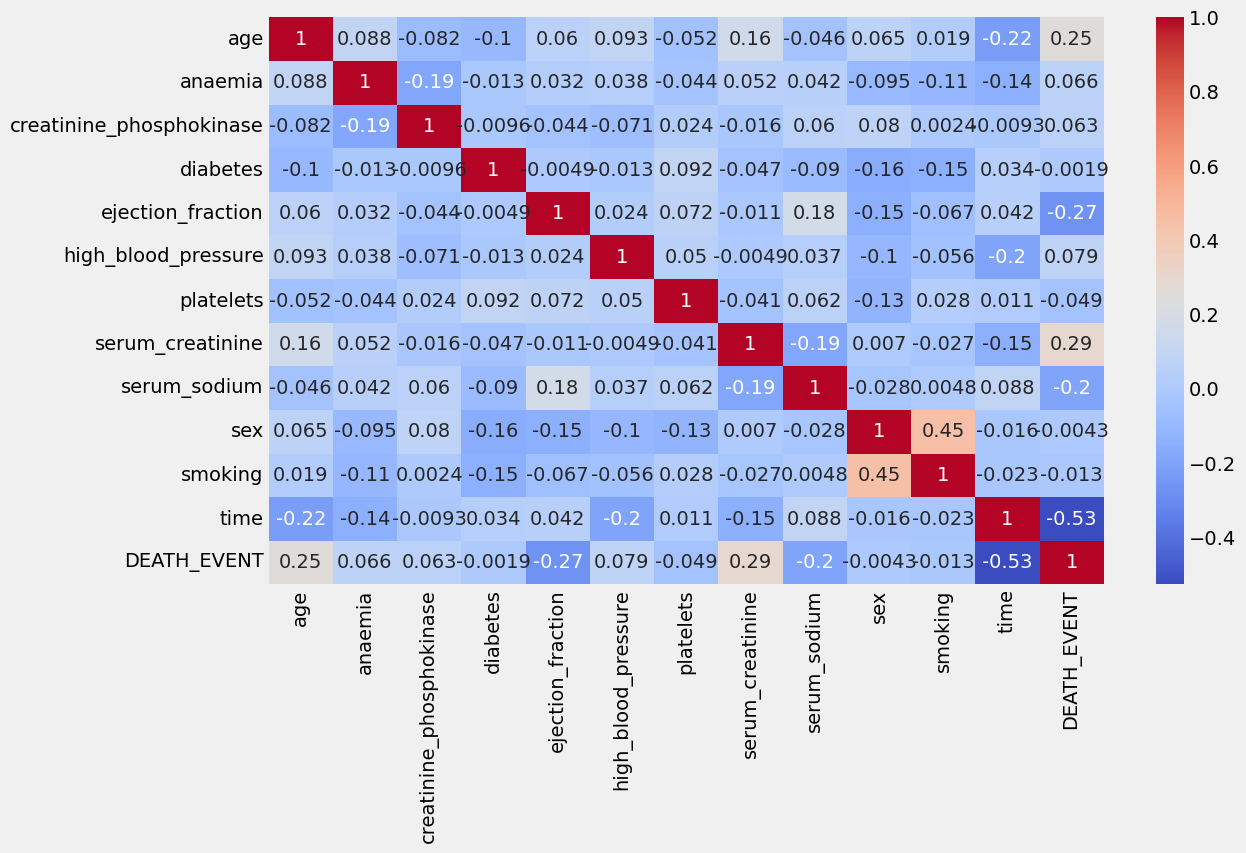

In [ ]:
plt.figure(figsize=(12, 7))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm");


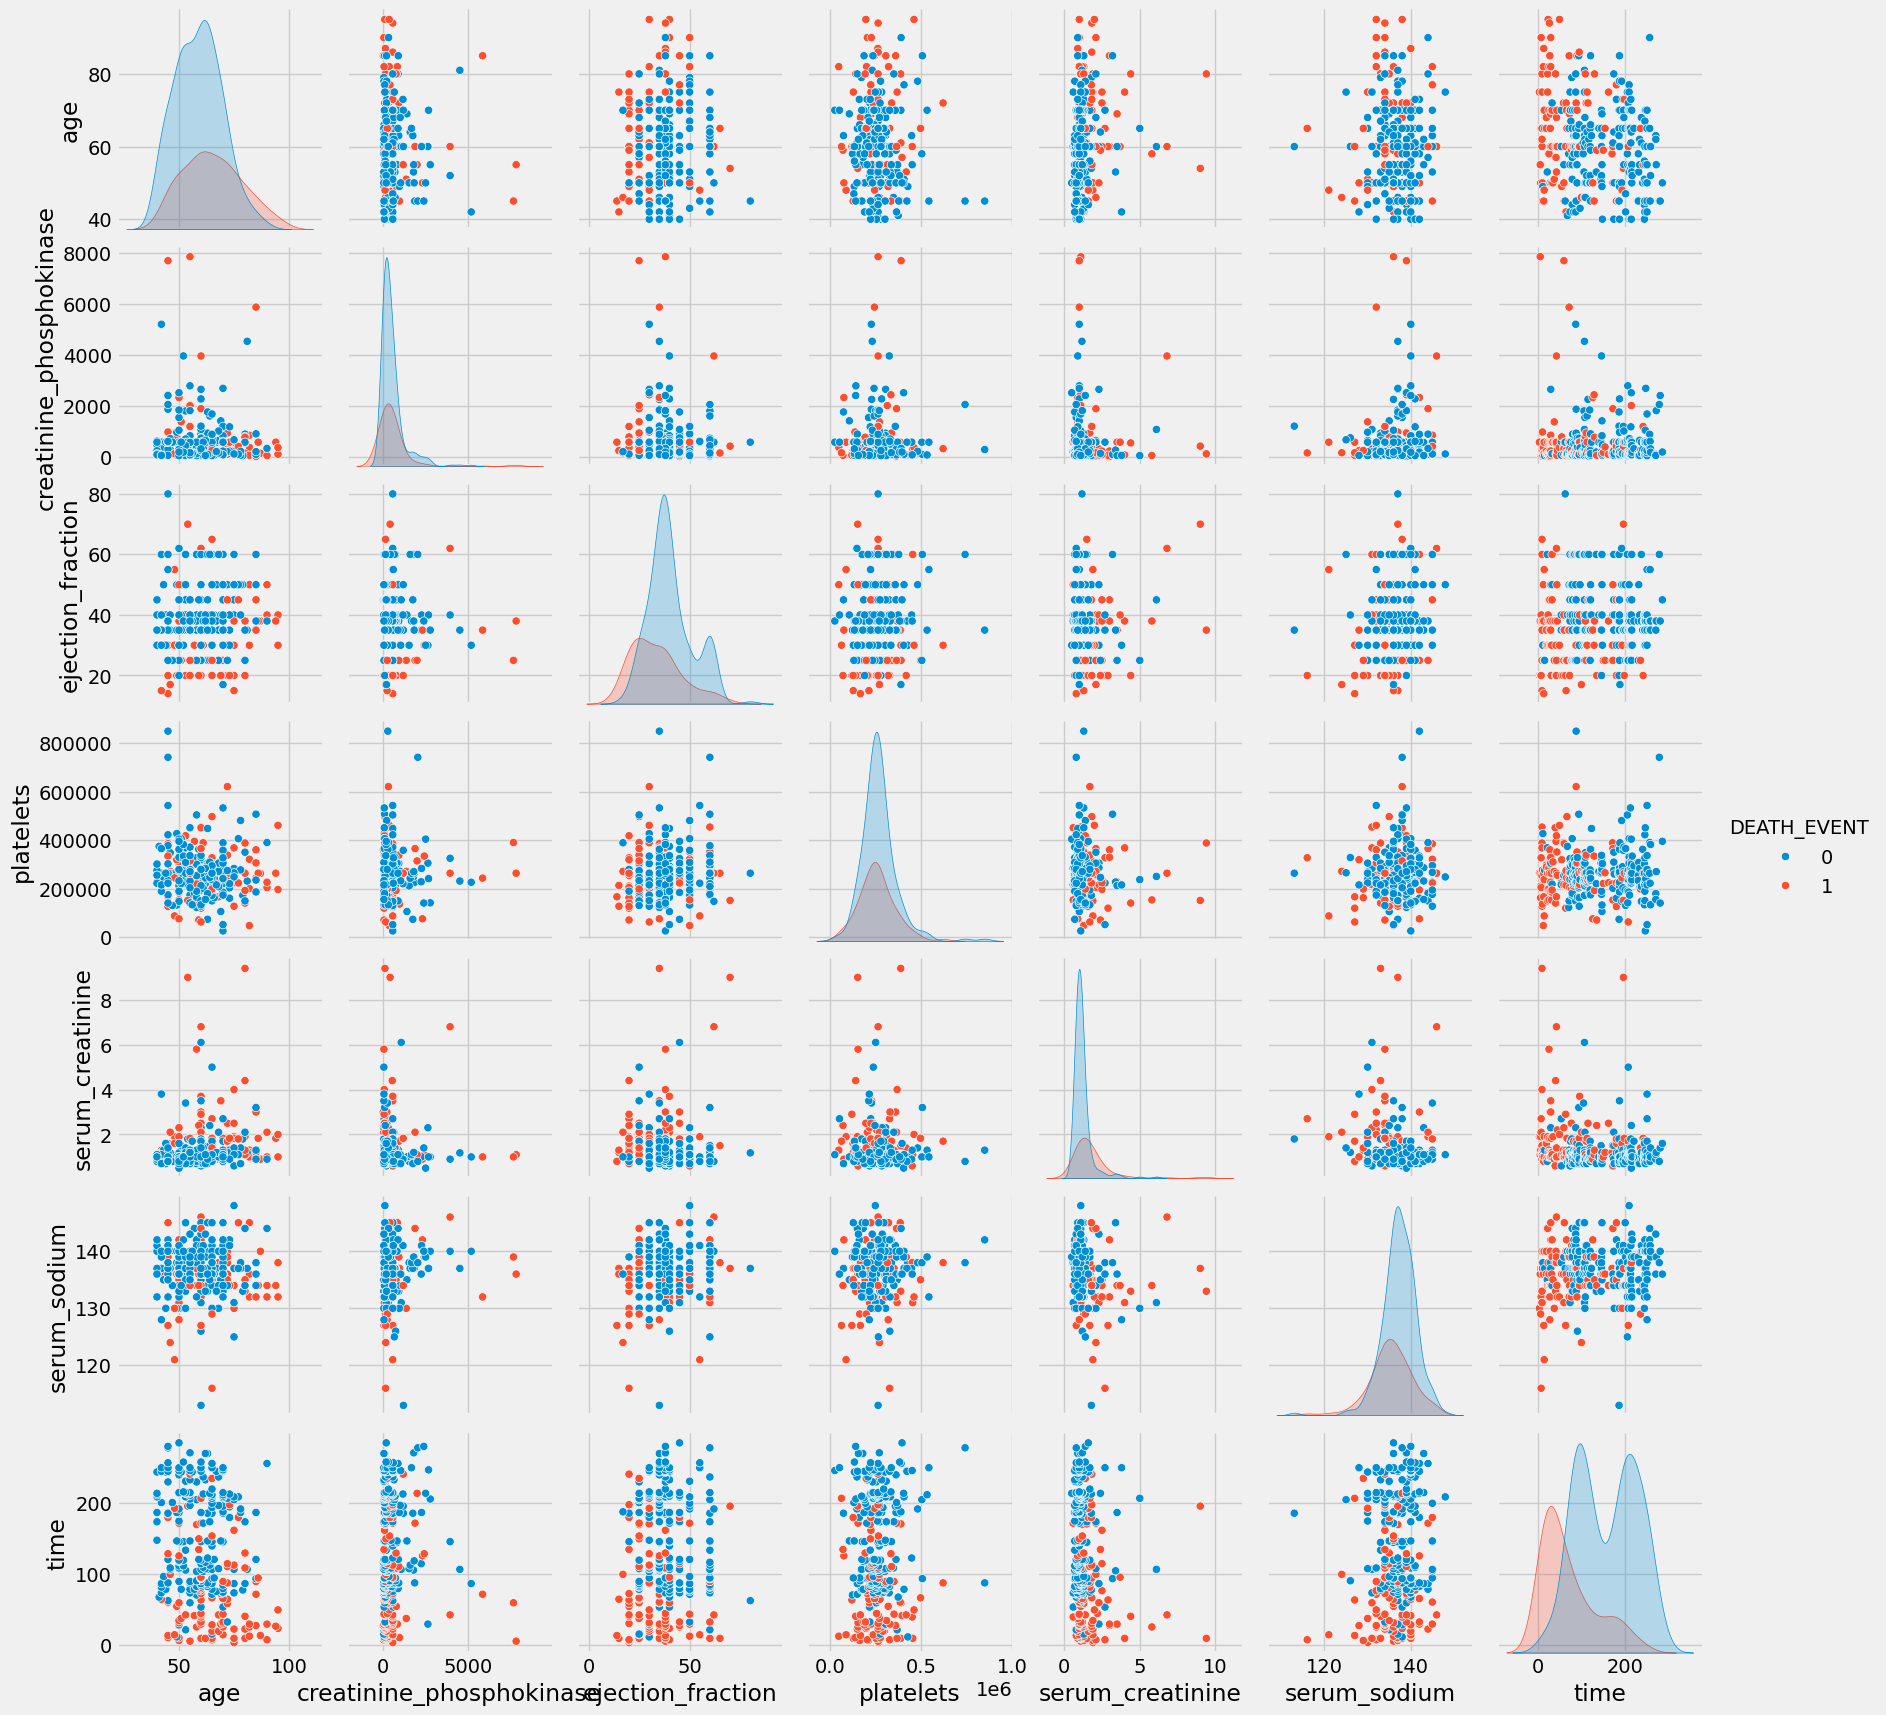

In [ ]:
sns.pairplot(data=df[["age", "creatinine_phosphokinase", "ejection_fraction", "platelets", "serum_creatinine", "serum_sodium", "time", "DEATH_EVENT"]],
             hue='DEATH_EVENT');


In [ ]:
duplicates = df.duplicated()
print(f"Number of duplicate rows: {duplicates.sum()}")


Number of duplicate rows: 0


In [ ]:
X = df.drop(columns='DEATH_EVENT')
y = df['DEATH_EVENT']


In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [ ]:
# Defining the model-building function for hyperparameter tuning
def build_model(hp):
    model = Sequential()

    # First Conv1D layer with tunable filters and kernel size
    model.add(Conv1D(filters=hp.Int('filters', min_value=32, max_value=128, step=32),
                     kernel_size=hp.Choice('kernel_size', values=[3, 5]),
                     activation='relu',
                     input_shape=(X_train.shape[1], 1)))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))

    # First LSTM layer with tunable units
    model.add(LSTM(units=hp.Int('units_lstm1', min_value=32, max_value=128, step=32), return_sequences=True))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))

    # Second LSTM layer with tunable units
    model.add(LSTM(units=hp.Int('units_lstm2', min_value=32, max_value=128, step=32)))

    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(units=hp.Int('units_dense', min_value=32, max_value=128, step=32), activation='relu'))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile model with a tunable learning rate
    model.compile(optimizer=tf.keras.optimizers.Adam(
                    hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='binary_crossentropy', metrics=['accuracy'])

    return model


In [ ]:
# Setting up Keras Tuner for hyperparameter tuning
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Number of hyperparameter combinations to try
    executions_per_trial=2,  # To reduce variance
    directory='tuner_results',
    project_name='heart_failure_prediction')


Reloading Tuner from tuner_results/heart_failure_prediction/tuner0.json


In [ ]:
# Perform the hyperparameter search
tuner.search(X_train, y_train, epochs=50, validation_data=(X_val, y_val), batch_size=32)


In [ ]:
# Get the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning:

Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 



In [ ]:
# Evaluate the model on the test data
test_loss, test_acc = best_model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7389 - loss: 0.8794 
Test accuracy: 0.7333333492279053


In [ ]:
# Predict probabilities for the test set
y_pred_proba = best_model.predict(X_test).ravel()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


In [ ]:
# Best hyperparameters
print(best_hyperparameters.values)


{'filters': 128, 'kernel_size': 3, 'dropout_rate': 0.1, 'units_lstm1': 96, 'units_lstm2': 64, 'units_dense': 64, 'learning_rate': 0.008751423768165307}


In [ ]:
# Compute ROC curve and ROC area for binary classification
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)


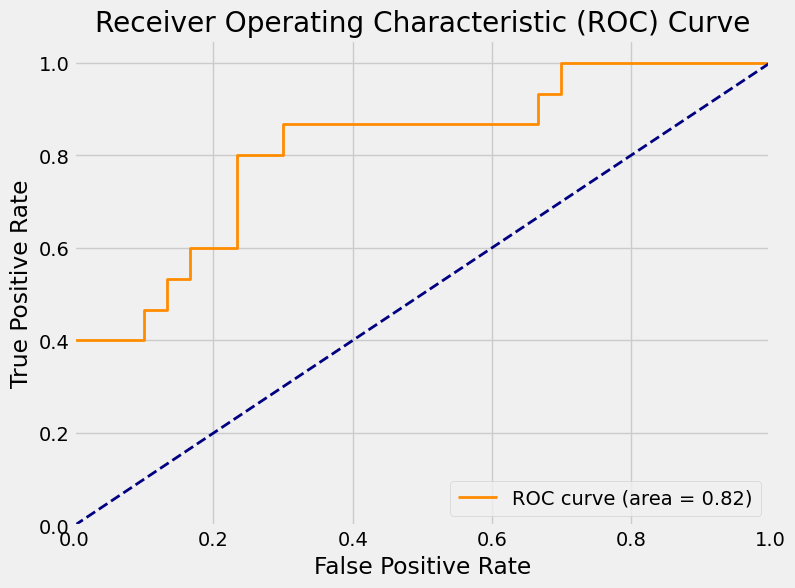

In [ ]:
# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [ ]:
!pip install lime
import lime
import lime.lime_tabular


In [ ]:
# Define explainer for tabular data
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.reshape(X_train.shape[0], -1),
    feature_names=df.columns[:-1],
    class_names=['No', 'Yes'],
    verbose=True,
    mode='classification'
)



In [ ]:
# Define a wrapper function that converts predictions to the expected format for LIME
def predict_proba_for_lime(X):
    # Reshape X to be 3D, matching the input shape expected by the model (samples, features, 1)
    X = X.reshape(X.shape[0], X.shape[1], 1)
    pred = best_model.predict(X)
    return np.hstack([(1 - pred), pred])  # Converting single output to probabilities for both classes


# Choose an instance from X_test
i = 0

# Use the wrapper function for predict_proba
exp = explainer.explain_instance(
    X_test[i].reshape(-1),
    predict_proba_for_lime,
    num_features=10
)

exp.show_in_notebook()



157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Intercept 0.2596233682416502
Prediction_local [0.67140508]
Right: 0.108753815
